# HBC 722 $L_{acc}$ and $T_{max}$

### Imports

In [1]:
import numpy as np
from scipy import optimize
from scipy import interpolate
from scipy import integrate
from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
from fu_ori_functions_oct29_copy import *
from fu_ori_classes_oct29_copy import *
import matplotlib.gridspec as gridspec
from PyAstronomy import pyasl
import scipy.signal as signal


import emcee
import corner
import time
%matplotlib inline 

In [2]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16

In [3]:
ATM_TABLE = dict()
ATMOS_FACTOR = 100

In [4]:
def getDataArrayMOD(data_file):
    txt = open(data_file)
    fulltxt = txt.readlines()
    # Cleaning lines
    newtxt = []
    for i in range(0,len(fulltxt), 2):
        line = fulltxt[i][:-1]
        line = line.split()
        if line[0] == '#':
            line = [line[1], line[2]]
        newtxt.append(line)
    # Casting as floats
    newtxt = np.array(newtxt).astype(np.float64)
    return newtxt

In [5]:
def direcToArray(directory):
    for temp in range(2000, 10000+ATMOS_FACTOR, ATMOS_FACTOR):
        for grav in [1.5, 4.0]:
            try:
                atmos_file = directory + 'pr.lte' + str(int(temp/ATMOS_FACTOR)) \
                        + '-' + str(grav) + '-0.0.spec'
                txt = open(atmos_file)
                fulltxt = txt.readlines()
                # Cleaning lines
                newtxt = []
                for i in range(len(fulltxt)):
                    line = fulltxt[i][:-1]
                    line = line.split()
                    newtxt.append(line)
        
                # Casting as floats
                newtxt = np.array(newtxt).astype(np.float64)
                
                # Choosing which model to use
                wav, lum = newtxt[:,0], newtxt[:,1]
                ATM_TABLE[(temp, grav)] = np.array([wav, lum])
            except:
                print('No atmosphere found for temp = ' + str(temp) + \
                      ' grav = ' + str(grav))

In [6]:
direcToArray('/Users/tonyrodriguez/Documents/Docs/2019 Summer/Stellar Atmospheres/')

No atmosphere found for temp = 7100 grav = 1.5
No atmosphere found for temp = 7100 grav = 4.0
No atmosphere found for temp = 7300 grav = 1.5
No atmosphere found for temp = 7300 grav = 4.0
No atmosphere found for temp = 7500 grav = 1.5
No atmosphere found for temp = 7500 grav = 4.0
No atmosphere found for temp = 7700 grav = 1.5
No atmosphere found for temp = 7700 grav = 4.0
No atmosphere found for temp = 7900 grav = 1.5
No atmosphere found for temp = 7900 grav = 4.0
No atmosphere found for temp = 8100 grav = 1.5
No atmosphere found for temp = 8100 grav = 4.0
No atmosphere found for temp = 8300 grav = 1.5
No atmosphere found for temp = 8300 grav = 4.0
No atmosphere found for temp = 8500 grav = 1.5
No atmosphere found for temp = 8500 grav = 4.0
No atmosphere found for temp = 8700 grav = 1.5
No atmosphere found for temp = 8700 grav = 4.0
No atmosphere found for temp = 8900 grav = 1.5
No atmosphere found for temp = 8900 grav = 4.0
No atmosphere found for temp = 9100 grav = 1.5
No atmosphere

### Interpolating grid of stellar atmospheres on same grid as data:

First, reading in data...

In [7]:
txt_in = getDataArrayMOD('hbc_out_new_calib.csv')
WAV_DAT = txt_in[:,0]
FLUX_DAT = txt_in[:,1]
FLUX_DAT_ERR = -0.01*FLUX_DAT

In [8]:
txt_in2 = getDataArrayMOD('hbc_out_new_calib_NEW_NIR.csv')
WAV_DAT2 = txt_in2[:,0]
FLUX_DAT2 = txt_in2[:,1]
FLUX_DAT_ERR2 = -0.01*FLUX_DAT2

In [9]:
import spectres

In [10]:
def getInterpTable(st_atm_table, waves_data):
    out_table = dict()
    for key in ATM_TABLE:
        wav, lum = ATM_TABLE[key]
#         interp_func = interpolate.interp1d(wav, lum, kind = 'linear')
#         out_table[key] = waves_data, interp_func(waves_data)
        out_table[key] =  waves_data, spectres.spectres(waves_data, wav, lum)
    return out_table

In [11]:
WAVES_DATA_LOGGED = WAV_DAT


In [12]:
len(WAVES_DATA_LOGGED)

435

In [13]:
np.logspace(np.log10(4000),np.log10(24100), 10)

array([ 4000.        ,  4883.39535656,  5961.88755213,  7278.56349711,
        8886.02579606, 10848.4942777 , 13244.37164535, 16169.37574839,
       19740.36361205, 24100.        ])

In [14]:
WAVES_DATA = 1e4*(10**WAVES_DATA_LOGGED)
# WAVES_DATA = np.logspace(np.log10(4000),np.log10(24100), 800)

In [15]:
ATM_TABLE_INTERP = getInterpTable(ATM_TABLE, WAVES_DATA)

In [16]:
ATM_TABLE_INTERP.keys()

dict_keys([(2000, 1.5), (2000, 4.0), (2100, 1.5), (2100, 4.0), (2200, 1.5), (2200, 4.0), (2300, 1.5), (2300, 4.0), (2400, 1.5), (2400, 4.0), (2500, 1.5), (2500, 4.0), (2600, 1.5), (2600, 4.0), (2700, 1.5), (2700, 4.0), (2800, 1.5), (2800, 4.0), (2900, 1.5), (2900, 4.0), (3000, 1.5), (3000, 4.0), (3100, 1.5), (3100, 4.0), (3200, 1.5), (3200, 4.0), (3300, 1.5), (3300, 4.0), (3400, 1.5), (3400, 4.0), (3500, 1.5), (3500, 4.0), (3600, 1.5), (3600, 4.0), (3700, 1.5), (3700, 4.0), (3800, 1.5), (3800, 4.0), (3900, 1.5), (3900, 4.0), (4000, 1.5), (4000, 4.0), (4100, 1.5), (4100, 4.0), (4200, 1.5), (4200, 4.0), (4300, 1.5), (4300, 4.0), (4400, 1.5), (4400, 4.0), (4500, 1.5), (4500, 4.0), (4600, 1.5), (4600, 4.0), (4700, 1.5), (4700, 4.0), (4800, 1.5), (4800, 4.0), (4900, 1.5), (4900, 4.0), (5000, 1.5), (5000, 4.0), (5100, 1.5), (5100, 4.0), (5200, 1.5), (5200, 4.0), (5300, 1.5), (5300, 4.0), (5400, 1.5), (5400, 4.0), (5500, 1.5), (5500, 4.0), (5600, 1.5), (5600, 4.0), (5700, 1.5), (5700, 4.0), (

In [17]:
class FUOriEnvironment:
    
    # Initializer / Instance Attributes
    def __init__(self, wave_lower_SED, wave_upper_SED):
        
        self.wave_lower_SED = wave_lower_SED
        self.wave_upper_SED = wave_upper_SED
        
        # Storing classes
        self.fuori = []
        
    # instance methods
    
    # Creating FU Ori object as accretion disk
    def createFUOri(self, r_star, r_outer, m_star, m_dot, inc, dist, grav, direc, a_v, atm_table, pl_index):
        fuori = FUOri(r_star, r_star, r_outer, m_star, m_dot, np.radians(inc), a_v, atm_table, pl_index)
        fuori.setAnnuliValues(10000, 2000, 200, 2*R_STAR)
        fuori.createAnnuliFromDirec(grav, direc, 'stellar atmospheres')
        fuori.createModelSpectrum('stellar atmospheres', False)
        self.fuori.append(fuori)

### Making an instance of the class

In [18]:
PARAMS = [25, 7000, 3.16]
CONST = (3/(8*np.pi*SIG_SB))*(1/7)*(36/49)**3

In [19]:
L_ACC = PARAMS[0]*L_SUN
T_MAX = PARAMS[1]
R_STAR = (2*L_ACC*CONST/T_MAX**4)**0.5
M_STAR = 0.5*M_SUN
R_OUTER = 100 * R_STAR
M_DOT = 2*L_ACC*R_STAR/ G / M_STAR
A_V = PARAMS[2]
INC = 30
DIST = 795*3.08567758128e18
DIREC = '/Users/tonyrodriguez/Documents/Docs/2019 Summer/Stellar Atmospheres/'

In [20]:
%time gaia17bpi_env = FUOriEnvironment(3.0e3, 28.5e3)
%time gaia17bpi_env.createFUOri(r_star = R_STAR, r_outer = R_OUTER, m_star = M_STAR,\
                          m_dot = M_DOT, inc = INC, a_v = A_V,dist = DIST, grav = 1.5, \
                                direc = DIREC, atm_table=ATM_TABLE_INTERP, pl_index=0)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
CPU times: user 3.93 ms, sys: 376 µs, total: 4.3 ms
Wall time: 4.02 ms


In [21]:
gaia17bpi_env.fuori[0].temps[0]

7000.0

In [22]:
gaia17bpi_env.fuori[0].getTotalLum()/L_SUN

24.785981250093855

### Quick minimization routine

In [23]:
def getLstSqrs(theta):
    lacc, tmax, a_v = theta
    const = (3/(8*np.pi*SIG_SB))*(1/7)*(36/49)**3
    lacc *= L_SUN
    m_star = 2*M_SUN
    r_star = (2*lacc*const/tmax**4)**0.5
    m_dot = 2*lacc*r_star/ G / m_star

    inc = 30
#     a_v = 3.

    gaia17bpi_env = FUOriEnvironment(3.0e3, 28.5e3)
    try:
        gaia17bpi_env.createFUOri(r_star = r_star, r_outer = R_OUTER, m_star = m_star,\
                          m_dot = m_dot, inc = inc, a_v = a_v, dist = DIST, grav = 1.5, \
                              direc = DIREC, atm_table=ATM_TABLE_INTERP, pl_index=0)
    except:
        gaia17bpi_env.createFUOri(r_star = r_star*2, r_outer = R_OUTER, m_star = m_star,\
                          m_dot = m_dot, inc = inc, a_v = a_v, dist = DIST, grav = 1.5, \
                              direc = DIREC, atm_table=ATM_TABLE_INTERP, pl_index=0)

    x = WAV_DAT
    # Converting units to properly compare model to data
    x_new = (10**x)*1e4
    modSpec = np.zeros(len(x_new))
    modSpec = gaia17bpi_env.fuori[0].mod_spec_lums
    modSpec = pyasl.unred(x_new, modSpec, -a_v/3.1)
    flux = np.cos(np.radians(inc))*modSpec/(2*np.pi*DIST**2)

    model = np.log10(x_new*flux*1e-8)
    data = FLUX_DAT

    return np.sum((model - data)**2)

In [24]:
from scipy import optimize
x0 = [30, 7200, 3]
optimize.minimize(getLstSqrs, x0, method='Nelder-Mead', tol=1e-6)

 final_simplex: (array([[2.71973376e+01, 7.50000007e+03, 3.35945023e+00],
       [2.71973367e+01, 7.50000007e+03, 3.35945020e+00],
       [2.71973381e+01, 7.50000007e+03, 3.35945025e+00],
       [2.71973372e+01, 7.50000007e+03, 3.35945022e+00]]), array([1.25487686, 1.25487686, 1.25487686, 1.25487686]))
           fun: 1.2548768605758231
       message: 'Optimization terminated successfully.'
          nfev: 315
           nit: 173
        status: 0
       success: True
             x: array([2.71973376e+01, 7.50000007e+03, 3.35945023e+00])

In [25]:
gaia17bpi_env.fuori[0].temps[11]

5000.0

In [26]:
wav, lum = gaia17bpi_env.fuori[0].mod_spec_waves, gaia17bpi_env.fuori[0].mod_spec_lums
# wav1, lum1 = gaia17bpi_env.fuori[1].mod_spec_waves, gaia17bpi_env.fuori[1].mod_spec_lums
# wav2, lum2 = gaia17bpi_env.fuori[2].mod_spec_waves, gaia17bpi_env.fuori[2].mod_spec_lums

# wav3, lum3 = gaia17bpi_env.fuori[0].annuli[0].wavelengths, gaia17bpi_env.fuori[0].annuli[0].lums
# wav4, lum4 = gaia17bpi_env.fuori[0].annuli[11].wavelengths, gaia17bpi_env.fuori[0].annuli[11].lums
# wav5, lum5 = gaia17bpi_env.fuori[0].annuli[21].wavelengths, gaia17bpi_env.fuori[0].annuli[21].lums




lum = pyasl.unred(wav, lum, -PARAMS[2]/3.1)
# lum1 = pyasl.unred(wav, lum1, -PARAMS_2[3]/3.1)
# lum2 = pyasl.unred(wav, lum2, -PARAMS_3[3]/3.1)

# lum3 = 5e22*pyasl.unred(wav3, lum3, -PARAMS[3]/3.1)
# lum4 = 8e23*pyasl.unred(wav4, lum4, -PARAMS[3]/3.1)
# lum5 = 0.3e22*pyasl.unred(wav5, lum5, -PARAMS[3]/3.1)

### Plotting data with model

In [27]:
wav_mods = np.array([wav, wav1, wav2, wav3, wav4, wav5])
lum_mods = np.array([lum, lum1, lum2, lum3, lum4, lum5])

NameError: name 'wav1' is not defined

In [28]:
model_wav = np.log10(wav*1e-4)
model_wav_flux =  np.log10(lum*wav*1e-8*np.cos(np.radians(INC))/(2*np.pi*DIST**2))


In [29]:
b, a = signal.butter(1, 0.35, 'low', analog=False)
filtered_signal = signal.filtfilt(b, a,  model_wav_flux)


In [30]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [31]:
fl2 = spectres.spectres(WAV_DAT, WAV_DAT2, FLUX_DAT2)


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



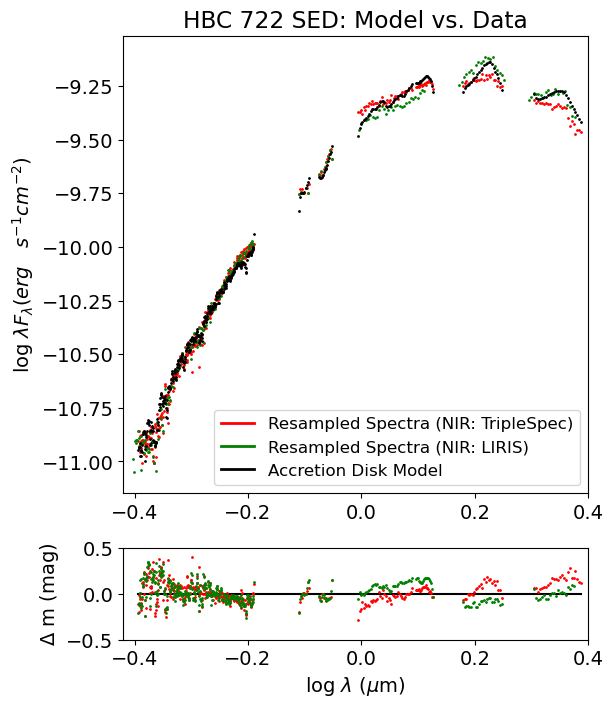

In [32]:
fig=plt.figure(figsize=(6, 8), dpi= 100)
gs = gridspec.GridSpec(2, 1,height_ratios=[5, 1])
plt.rcParams.update({'font.size': 14})

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


# plt.errorbar(WAV_DAT, FLUX_DAT, yerr=FLUX_DAT_ERR, marker='o', \
#              linestyle='', color='r', alpha=1, label='Palomar + IRTF \nResampled Spectra')

ax.plot(WAV_DAT, FLUX_DAT, 'ro', markersize=1, alpha=1, label='Resampled Spectra')
ax.plot(WAV_DAT2, FLUX_DAT2, 'go', markersize=1, alpha=1, label='Resampled Spectra')


# ax.plot(model_wav,model_wav_flux, \
#          'ko', markersize = 1,  label='Stellar Atmospheres \n Acc. Disk (unsmoothed)')

ax.plot(model_wav, filtered_signal,'ko' , markersize = 1,  label='Stellar Atmospheres \n Acc. Disk (smoothed)')


# ax2.plot(model_wav, 100*(model_wav_flux - FLUX_DAT)/model_wav_flux, 'o', markersize=1)
# ax2.plot(model_wav, np.zeros(len(model_wav_flux)), 'k--')

ax2.plot(model_wav, np.zeros(len(model_wav_flux)), 'k-')
ax2.plot(model_wav, (1/0.4)*np.log10((10**filtered_signal)/(10**FLUX_DAT)), 'ro', markersize=1)
ax2.plot(model_wav, (1/0.4)*np.log10((10**filtered_signal)/(10**fl2)), 'go', markersize=1)





ax2.set_xlabel(r'log $\lambda$ ($\mu$m)')
ax2.set_ylabel(r'$\Delta$ m (mag)')
ax2.set_xlim(-0.5, 0.4)
ax2.set_ylim(-0.5,0.5)


ax2.set_xlabel(r'log $\lambda$ ($\mu$m)')
ax.set_ylabel(r'log $\lambda F_\lambda (erg\quad s^{-1} cm^{-2})$')
# ax2.set_ylabel(r'Percent Error')

ax.set_title('HBC 722 SED: Model vs. Data')
# ax.set_ylim(-12.5, -8.7)

ax.set_xlim(-0.42, 0.4)
ax2.set_xlim(-0.42, 0.4)

legend_elements = [Line2D([0], [0], color='r', lw=2, label='Resampled Spectra (NIR: TripleSpec)'),
                   Line2D([0], [0], color='g', lw=2, label='Resampled Spectra (NIR: LIRIS)'),
                   Line2D([0], [0], color='k', lw=2, label='Accretion Disk Model')]
ax.legend(handles=legend_elements, fontsize=12)
# plt.savefig("sed_hbc722_NEW_min_chisq.png", dpi=200, bbox_inches='tight')
plt.show()

## MCMC Routine

In [58]:
def lnlike(theta, x, y, yerr):
    lacc, tmax= theta
    const = (3/(8*np.pi*SIG_SB))*(1/7)*(36/49)**3
    lacc *= L_SUN
    m_star = 0.5*M_SUN
    r_star = (2*lacc*const/tmax**4)**0.5
    m_dot = 2*lacc*r_star/ G / m_star
    
#     inc = np.degrees(np.arccos(30))
    inc = 30
    a_v = 3.16
    dist = 795*3.08567758128e18
    pl_index = 0
    try:
    
        gaia17bpi_env = FUOriEnvironment(3.0e3, 28.5e3)
        gaia17bpi_env.createFUOri(r_star = r_star, r_outer = R_OUTER, m_star = m_star,\
                              m_dot = m_dot, inc = inc, a_v = a_v, dist = dist, grav = 1.5, \
                                  direc = DIREC, atm_table=ATM_TABLE_INTERP, pl_index = pl_index)
    
    # Accounts for any random case where the model may not be generated properly given a certain combination
    # of parameters. This has only happened once, but it's presumably when the maximum temperature is too low.
    except:
        return 0
        
    
    # Converting units to properly compare model to data
    x_new = (10**x)*1e4
    modSpec = np.zeros(len(x_new))
    modSpec = gaia17bpi_env.fuori[0].mod_spec_lums
#     for i in range(len(x)):
#         modSpec[i] = gaia17bpi_env.getModSpecPoint(x[i], True)
    modSpec = pyasl.unred(x_new, modSpec, -a_v/3.1)
    flux = np.cos(np.radians(inc))*modSpec/(2*np.pi*(dist**2))
    

    model = np.log10(x_new*flux*1e-8)
    
    b, a = signal.butter(1, 0.35, 'low', analog=False)
    model = signal.filtfilt(b, a,  model)
    
    inv_sig = 1/yerr
    return np.sum(np.log((1/np.sqrt(2*np.pi))*inv_sig) - 0.5*((y - model)*inv_sig)**2)

In [59]:
L_ACC_LOW = 10
L_ACC_HIGH = 80

T_MAX_LOW = 4000
T_MAX_HIGH = 9000

A_V_LOW = 2
A_V_HIGH = 7

M_STAR_LOW = 0.1
M_STAR_HIGH = 2.0

In [60]:
def lnprior(theta):
    lacc, tmax= theta
    if L_ACC_LOW < lacc < L_ACC_HIGH\
    and T_MAX_LOW < tmax < T_MAX_HIGH:
        return 0.0
    return -np.inf

In [61]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp + lnlike(theta, x, y, yerr))

In [62]:
ndim, nwalkers = 2, 8
lacc_start = 30
tmax_start = 7200
a_v_start = 3.2
m_star_start = -5
inc_start = 0.5

start = np.array((lacc_start, tmax_start))
pos = [start + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

In [63]:
x = WAV_DAT
y_meas = FLUX_DAT
y_err = FLUX_DAT_ERR

In [64]:
len(WAV_DAT), len(gaia17bpi_env.fuori[0].mod_spec_lums)

(435, 435)

In [65]:
lnprob((lacc_start, tmax_start), x,y_meas,y_err)

355.9784705324584

In [66]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y_meas, y_err))
%time sampler.run_mcmc(pos, 8000)

CPU times: user 4min 34s, sys: 1.72 s, total: 4min 36s
Wall time: 4min 37s


State([[  25.00931012 6905.29487528]
 [  24.87274802 6920.47759397]
 [  24.37809715 7070.18710048]
 [  24.70211531 7015.44011417]
 [  24.84190662 7004.85771268]
 [  24.4976209  6905.42570571]
 [  24.17975159 6926.1250175 ]
 [  24.89179115 6997.81088298]], log_prob=[555.95773662 556.35966636 556.38557144 556.8320637  556.59700558
 555.53758685 554.28144991 556.46745276], blobs=None, random_state=('MT19937', array([2709483495, 3370480974,  746046884, 1338318384, 2815077349,
        437727185, 2927642308, 3004403821, 1497329624, 2698949935,
        757765319, 3937716247, 2384994293, 1989078491, 2289096345,
       1228095753,  402939498, 2592292821,  248666981, 1383036911,
       3840254844, 3217232288, 2190457599,  452687760, 4191301409,
        575157980, 1003482201, 2142338376, 3160954196,   15654160,
        209088442, 1082856459, 3939831248, 2193676240, 1928641623,
        924071119, 2889663797, 4114521382, 1551266309, 3555287455,
       2639891706, 3299627205,  573073899, 3559145701,

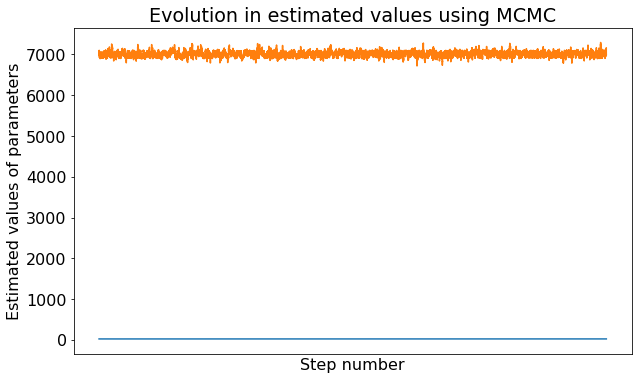

In [67]:
samples = sampler.chain[:, 4000:, :].reshape((-1, ndim))
fig = plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 16})

plt.plot(samples)
plt.xlabel('Step number')
plt.ylabel('Estimated values of parameters')
plt.title('Evolution in estimated values using MCMC')
plt.xticks([])
plt.show()

Quantiles:
[(0.16, 24.3530380059177), (0.5, 24.655019806718137), (0.84, 24.94790723538975)]
Quantiles:
[(0.16, 6942.6462177810845), (0.5, 7010.681071997318), (0.84, 7073.730081297524)]


/Users/tonyrodriguez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


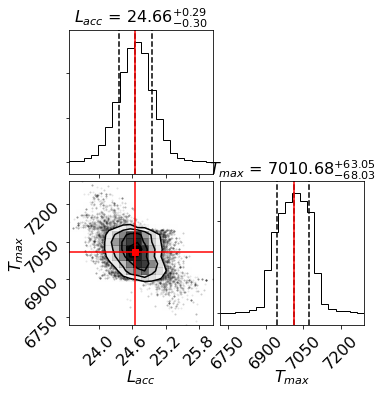

In [69]:
median_calcuated = np.median(samples, axis=0)

fig = corner.corner(samples, labels=[r'$L_{acc}$', r'$T_{max}$', r'$A_V$', r'$\cos i$'], verbose=True,
                       quantiles=(0.16, 0.5,0.84), plot_contours=True, scale_hist=True,
                       show_titles=True, title_kwargs={"fontsize": 16})

axes = np.array(fig.axes).reshape((ndim, ndim))

for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(median_calcuated[i], color="r")
    
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(median_calcuated[xi], color="r")
        ax.axhline(median_calcuated[yi], color="r")
        ax.plot(median_calcuated[xi], median_calcuated[yi], "sr")

fig.show()
# fig.savefig("hbc722_corner_lacc_select.png", dpi=180)

In [ ]:
[0.71, 0.63, -5.41, 4.08, 1.56]